In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

2024-05-09 23:58:26.963660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 23:58:26.963757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 23:58:27.096741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# # Data Preperation

In [2]:
# create our labels
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [3]:
# append all images to lists
X_train = []
y_train = []
image_size = 300
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

100%|██████████| 74/74 [00:00<00:00, 78.86it/s]


In [4]:
# convert to arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

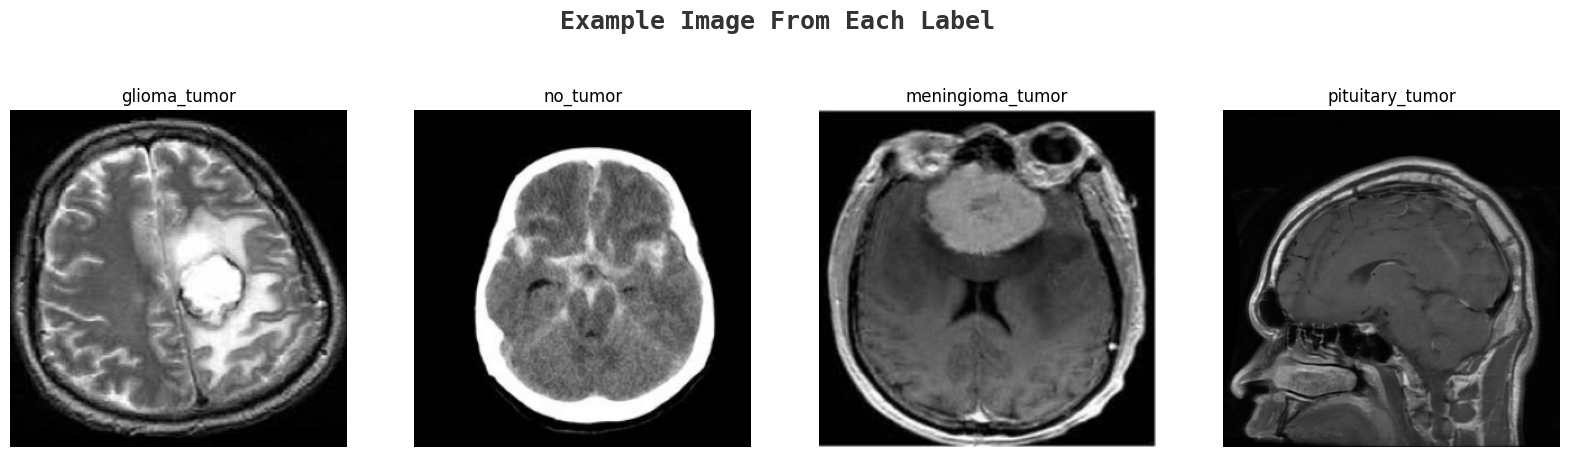

In [5]:
# create figure to look at sample image
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Example Image From Each Label',
         size=18,
         fontweight='bold',
         fontname='monospace',
         color='black',
         y=0.62,
         x=0.4,
         alpha=0.8)

# upload random image
import random
for i in labels:
    j=random.randint(0, len(X_train)-1)
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
# shuffle data
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
# look at shape
X_train.shape

(3264, 300, 300, 3)

In [8]:
# create the training and testing split from our data
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=101)

In [9]:
# convert labels to categorical numbers
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# # Transfer Learning

In [10]:
# import EfficientNetB0 weights
effnet = EfficientNetB0(weights='imagenet',
                        include_top=False,
                        input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# apply weights to our model
model = effnet.output

# global average for easier computation
model = tf.keras.layers.GlobalAveragePooling2D()(model)

# dropout to avoid overfitting
model = tf.keras.layers.Dropout(rate=0.5)(model)

# output layer
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [12]:
# look at model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [13]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer = 'Adam',
              metrics= ['accuracy'])

In [14]:
n = 15

In [15]:
# train the model on our data
history = model.fit(X_train,y_train,validation_split=0.1, epochs = 15, verbose=1, batch_size=32)

Epoch 1/15


I0000 00:00:1715299246.914300      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7669 - loss: 0.5975 - val_accuracy: 0.8931 - val_loss: 0.3098
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.9504 - loss: 0.1692 - val_accuracy: 0.5038 - val_loss: 1.8163
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.9633 - loss: 0.1041 - val_accuracy: 0.9160 - val_loss: 0.2208
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.9787 - loss: 0.0693 - val_accuracy: 0.9008 - val_loss: 0.3557
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.9853 - loss: 0.0539 - val_accuracy: 0.9466 - val_loss: 0.2182
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.9833 - loss: 0.0522 - val_accuracy: 0.9275 - val_loss: 0.2346
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.9788 - loss: 0.0590 - val_accuracy: 0.9237 - val_loss: 0.2379
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.9861 - loss: 0.0490 - val_accuracy: 0.9504 

# # Model Evaluation

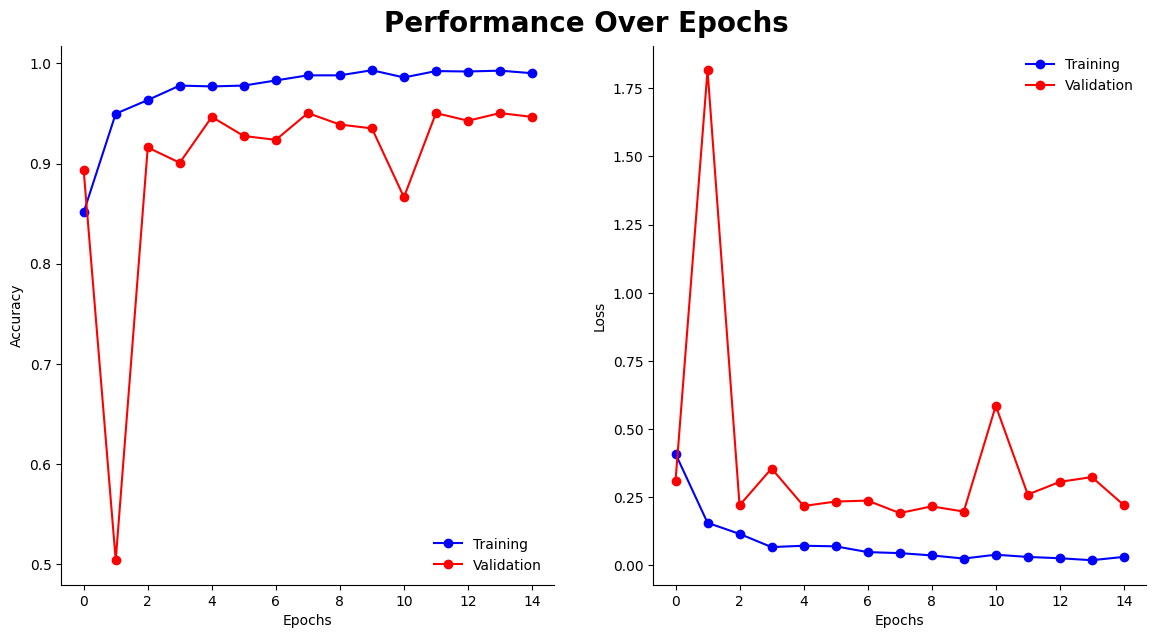

In [16]:
# look at chart of accuracy & loss
filterwarnings('ignore')

epochs = [i for i in range(n)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(0.5, 0.9, 'Performance Over Epochs',
         ha='center',
         fontsize=20,
         fontweight='bold')

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',color='blue',
           label = 'Training')
ax[0].plot(epochs, val_acc, marker='o',color='red',
           label = 'Validation')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',color='blue',
           label ='Training')
ax[1].plot(epochs, val_loss, marker='o',color='red',
           label = 'Validation')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

fig.show()

In [17]:
plt.savefig('accuracy_loss.png')

<Figure size 640x480 with 0 Axes>

In [18]:
# create predicted values to compare vs actual ones
pred = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step


In [19]:
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

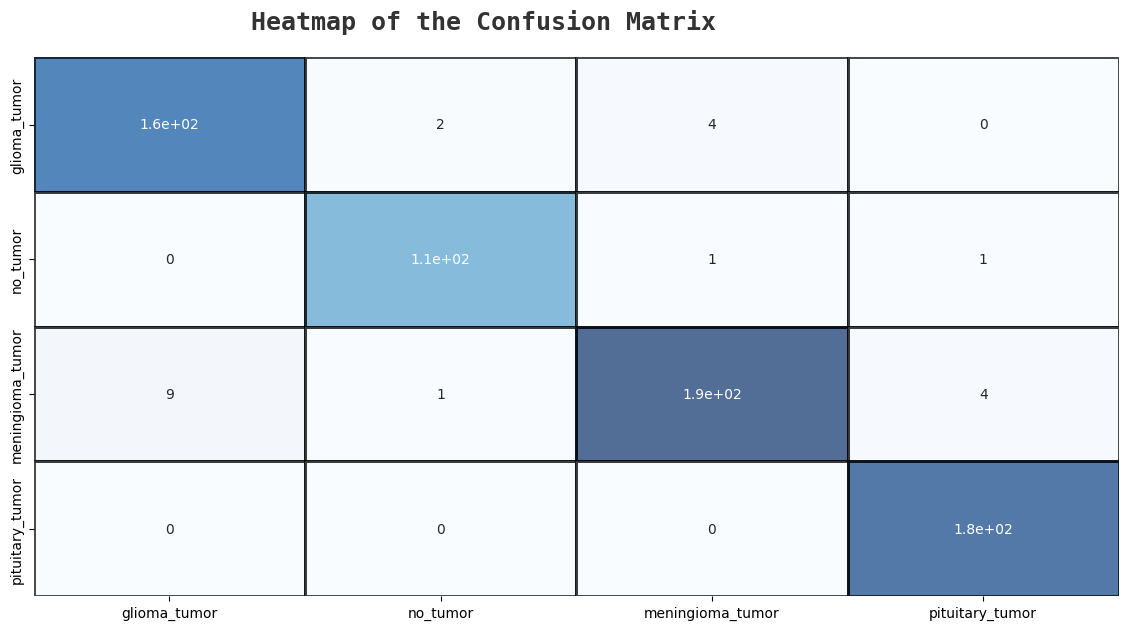

In [20]:
# plot confusion matrix
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap='Blues',
            alpha=0.7,
            linewidths=2,
            linecolor='black',
            cbar=False)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color='black',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [21]:
plt.savefig('confusion_matrix.png')

<Figure size 640x480 with 0 Axes>

In [22]:
print(classification_report(y_test_new,pred, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.96      0.96       168
        no_tumor       0.97      0.98      0.98       108
meningioma_tumor       0.97      0.93      0.95       201
 pituitary_tumor       0.97      1.00      0.99       176

        accuracy                           0.97       653
       macro avg       0.97      0.97      0.97       653
    weighted avg       0.97      0.97      0.97       653



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 100.00%



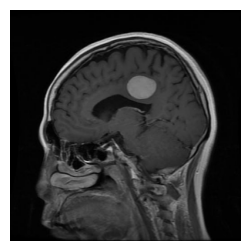

In [23]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, image_size, image_size, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class] 

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

# # Download Model

In [24]:
model.save('effNetB0_300.keras')